<a href="https://colab.research.google.com/github/Diego-CB/DS-Proyecto/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print hola cristian

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Diego-
[nltk_data]     CB\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
data = pd.read_csv('./dataset_keaggle/train.csv')

In [ ]:
data.shape

(36765, 5)

In [ ]:
data.columns

Index(['discourse_id', 'essay_id', 'discourse_text', 'discourse_type',
       'discourse_effectiveness'],
      dtype='object')

In [ ]:
data.dtypes

discourse_id               object
essay_id                   object
discourse_text             object
discourse_type             object
discourse_effectiveness    object
dtype: object

In [ ]:
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [ ]:
data.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,0013cc385424,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


In [ ]:
data.isnull().sum()

discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
dtype: int64

In [ ]:
data.corr()

ValueError: could not convert string to float: '0013cc385424'

In [ ]:
columns = data.columns
numeric_data = data._get_numeric_data().columns

categorical_data = set(columns) - set(numeric_data)
print("-> Columnas con valores numericos \n ",numeric_data ,'\n')
print("-> Columnas con valores categoricos\n ",categorical_data)

-> Columnas con valores numericos 
  Index([], dtype='object') 

-> Columnas con valores categoricos
  {'discourse_id', 'discourse_type', 'discourse_text', 'discourse_effectiveness', 'essay_id'}


Como todo el dataset es texto pues se busca trabajar con natural language processing tomaremos una ruta distinta para explorar los datos.

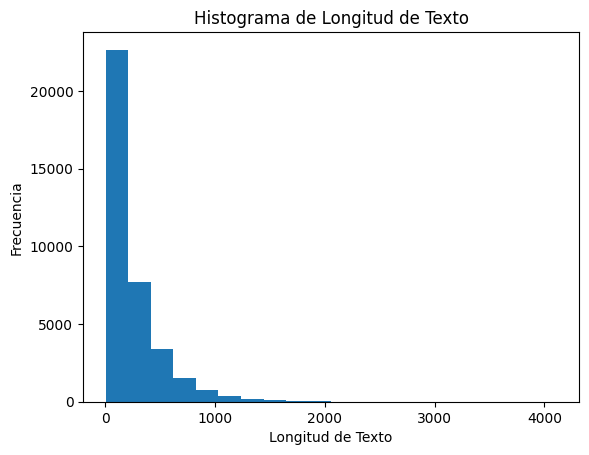

In [ ]:
data['text_lenght'] = data['discourse_text'].apply(len)
plt.hist(data['text_lenght'], bins=20)  # Cambia el valor de bins según tus preferencias
plt.title('Histograma de Longitud de Texto')
plt.xlabel('Longitud de Texto')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
texto_combinado = ' '.join(data['discourse_text'])
vocabulario = sorted(set(texto_combinado))

letras = [c for c in vocabulario if c.isalpha()]
numeros = [c for c in vocabulario if c.isdigit()]
especiales = [c for c in vocabulario if c not in string.ascii_letters + string.digits]

# Imprimir las categorías y sus contenidos
print("Letters:", ''.join(letras))
print("Numbers:", ''.join(numeros))
print("Especial Characters:", ''.join(especiales))
print("Vocab size:",len(vocabulario))

Letters: ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÂÃËåþ
Numbers: 0123456789
Especial Characters: 
 !"#$%&'()*+,-./:;=>?@[\]^_`{|}~ ¢¨®°´ÂÃËåþ
Vocab size: 113


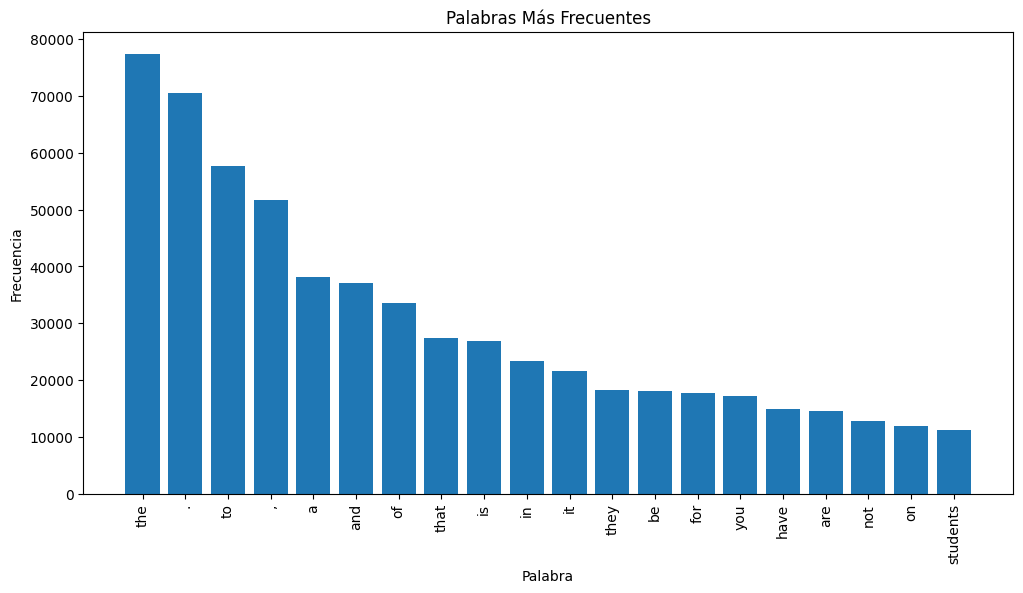

In [ ]:
data['tokens'] = data['discourse_text'].apply(word_tokenize)
word_frequency = Counter(word for words in data['tokens'] for word in words)
most_common_words = word_frequency.most_common(20)  # Cambia el número según tus preferencias

# Separar las palabras y las frecuencias en listas separadas
words, frequencies = zip(*most_common_words)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.title('Palabras Más Frecuentes')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Para rotar las etiquetas en el eje x
plt.show()

In [ ]:
n = 2  # Número de palabras por n-grama (en este caso, bigramas)
data['bigrams'] = data['tokens'].apply(lambda x: list(ngrams(x, n)))

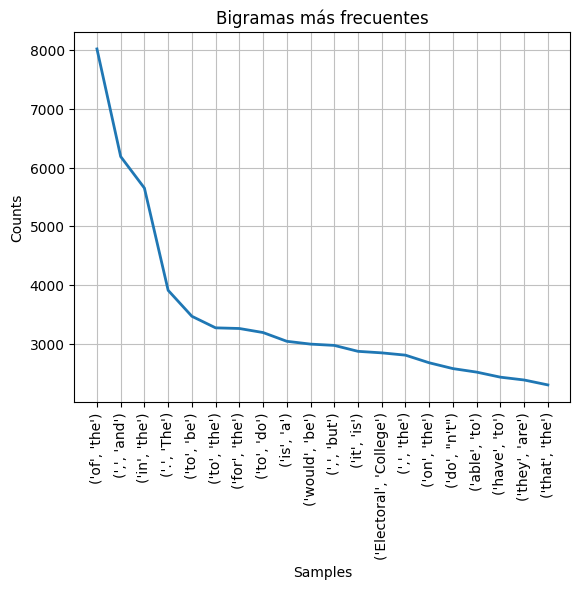

<Axes: title={'center': 'Bigramas más frecuentes'}, xlabel='Samples', ylabel='Counts'>

In [ ]:
all_bigrams = [bigram for sublist in data['bigrams'] for bigram in sublist]

# Calcular la frecuencia de los bigramas
bigram_freq = nltk.FreqDist(all_bigrams)

# Graficar los 20 bigramas más frecuentes
bigram_freq.plot(20, title='Bigramas más frecuentes')

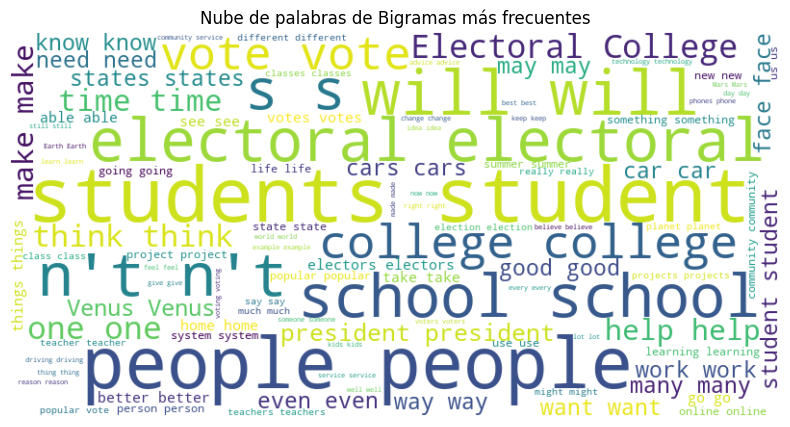

In [ ]:
bigrams_text = ' '.join([' '.join(bigram) for bigram in all_bigrams])

# Crear una nube de palabras de los bigramas más frecuentes
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(bigrams_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de Bigramas más frecuentes')
plt.show()

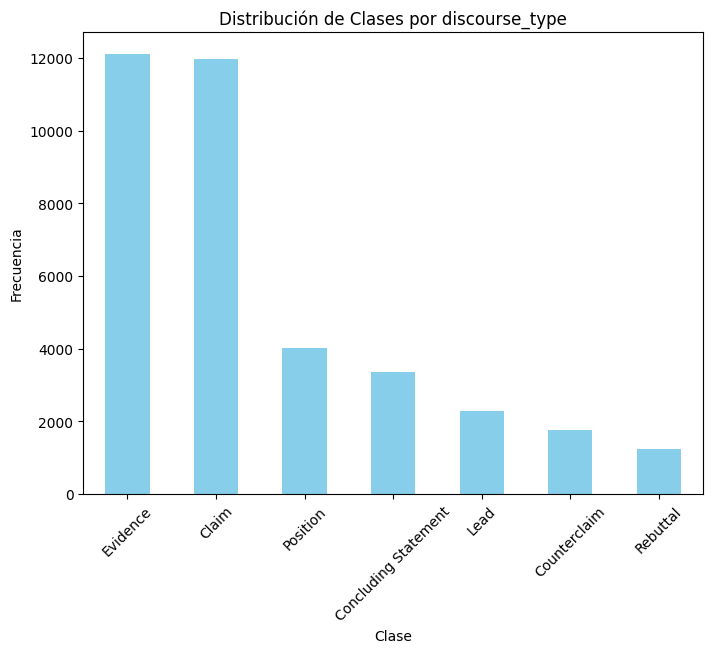

In [ ]:
class_counts = data['discourse_type'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases por discourse_type')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

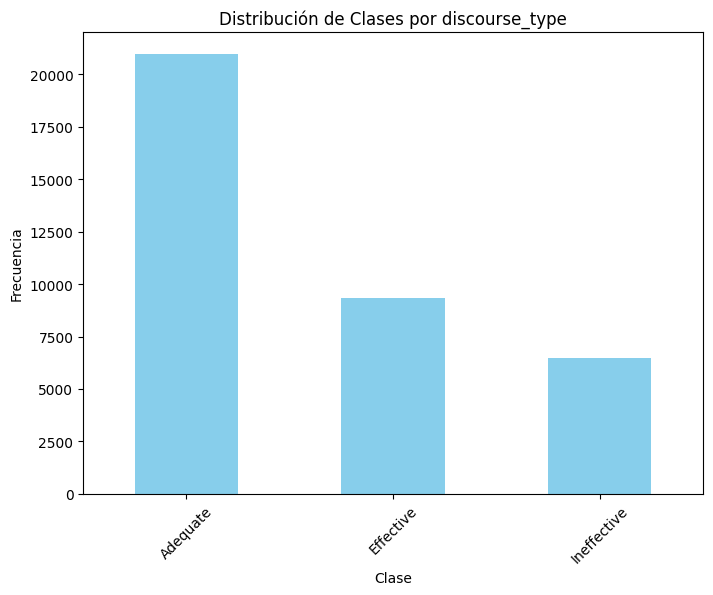

In [ ]:
class_counts = data['discourse_effectiveness'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases por discourse_type')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()